Will save outputs in: 20250113_013810_displacement_plots
Average displacement in X: -0.1517 m
Average displacement in Y: 0.7342 m
Total displacement magnitude: 0.7497 m
Total time: 17.5333 s
Average speed: 0.0428 m/s


/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/2836580520.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')  # black -> white


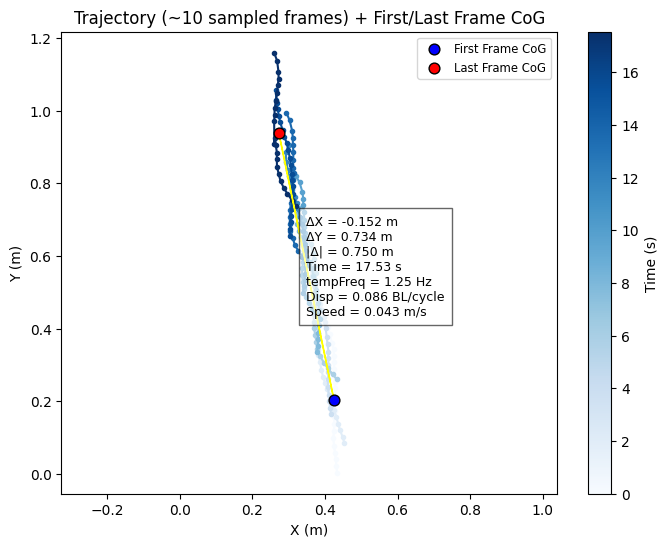


Done! Figure and a copy of the original CSV are in: 20250113_013810_displacement_plots


In [13]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# For color mapping
import matplotlib.cm as cm
import matplotlib.colors as mcolors

tempFreq = 1.25  # example parameter
bodyLength = 0.4 #m

##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_displacement_plots"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/40cm_noThresh_trial_1/40cm_run3DLC_resnet50_40cm_newOct1shuffle1_100000_filtered.csv'

# (Optional) Copy the original CSV into the output folder
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.55

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 884

# Video frame rate
video_fps = 30

# Load the CSV (DLC multi-level headers: rows 1 & 2)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates; drop rows with NaN
x_coords = data.xs('x', level=1, axis=1).dropna()
y_coords = data.xs('y', level=1, axis=1).dropna()

##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
n_drop_front = 0
n_drop_end = 0

if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

##############################################################################
# 2.2) CONVERT PIXELS -> METERS
##############################################################################
def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coords to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

x_m, y_m = pixels_to_meters(x_coords, y_coords)
x_coords = x_m
y_coords = y_m

##############################################################################
# 3) CALCULATE AVERAGE DISPLACEMENT (FIRST FRAME -> LAST FRAME)
##############################################################################

N_frames = x_coords.shape[0]
last_frame_idx = N_frames - 1

# First-frame CoG (mean of all markers)
mean_x_first = x_coords.iloc[0].mean()
mean_y_first = y_coords.iloc[0].mean()

# Last-frame CoG
mean_x_last = x_coords.iloc[last_frame_idx].mean()
mean_y_last = y_coords.iloc[last_frame_idx].mean()

# Displacement
disp_x = mean_x_last - mean_x_first
disp_y = mean_y_last - mean_y_first
disp_mag = np.sqrt(disp_x**2 + disp_y**2)

# Total time from first to last frame
total_time_s = (N_frames - 1) / video_fps
avg_speed = disp_mag / total_time_s  # m/s

print(f"Average displacement in X: {disp_x:.4f} m")
print(f"Average displacement in Y: {disp_y:.4f} m")
print(f"Total displacement magnitude: {disp_mag:.4f} m")
print(f"Total time: {total_time_s:.4f} s")
print(f"Average speed: {avg_speed:.4f} m/s")

##############################################################################
# 4) PLOT: TRAJECTORY (~10 FRAMES) COLORED BY TIME + FIRST/LAST FRAME CoG
##############################################################################

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Trajectory (~10 sampled frames) + First/Last Frame CoG")

# ~10 frames sampled across the entire sequence
n_samples = 10
sample_frames = np.linspace(0, last_frame_idx, n_samples, dtype=int)

# We'll color by time (in seconds):
sample_times = sample_frames / video_fps  # time for each sampled frame

# Use a sequential colormap from dark at t=0 to light at t=total_time_s
cmap = cm.get_cmap('Blues')  # black -> white
norm = mcolors.Normalize(vmin=0, vmax=total_time_s)

# Plot raw markers for each sampled frame
for i, f_idx in enumerate(sample_frames):
    this_time = sample_times[i]  # seconds
    frame_color = cmap(norm(this_time))
    ax.plot(
        x_coords.iloc[f_idx],
        y_coords.iloc[f_idx],
        'o-',
        markersize=3,
        color=frame_color,
        zorder=2
    )

# Plot CoG for first frame and last frame
ax.scatter(
    mean_x_first, mean_y_first,
    color='blue', s=60, edgecolors='k',
    zorder=10, label='First Frame CoG'
)
ax.scatter(
    mean_x_last, mean_y_last,
    color='red', s=60, edgecolors='k',
    zorder=10, label='Last Frame CoG'
)

# Draw arrow from first-frame CoG to last-frame CoG
ax.arrow(
    mean_x_first, mean_y_first,
    disp_x, disp_y,
    head_width=0.005, length_includes_head=True,
    color='yellow', zorder=9
)

# Annotate displacement & average speed
mid_x = mean_x_first + disp_x * 0.5
mid_y = mean_y_first + disp_y * 0.5

annotation_text = (
    f"ΔX = {disp_x:.3f} m\n"
    f"ΔY = {disp_y:.3f} m\n"
    f"|Δ| = {disp_mag:.3f} m\n"
    f"Time = {total_time_s:.2f} s\n"
    f"tempFreq = {tempFreq:.2f} Hz\n"
    f"Disp = {disp_mag/bodyLength/(total_time_s*tempFreq):.3f} BL/cycle\n"
    f"Speed = {avg_speed:.3f} m/s"
)

ax.text(
    mid_x, mid_y,
    annotation_text,
    fontsize=9,
    ha='left', va='center',
    bbox=dict(facecolor='white', alpha=0.6, pad=5),
    zorder=11
)

# Create a colorbar that maps time in [0, total_time_s] to the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Array not strictly needed, but required for colorbar
cb = fig.colorbar(sm, ax=ax)
cb.set_label("Time (s)")

ax.axis('equal')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend(fontsize='small', loc='best')

fig_save_path = os.path.join(save_folder, "figure_time_colormap.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

print("\nDone! Figure and a copy of the original CSV are in:", save_folder)


Will save outputs in: 20250113_015735_displacement_plots
Average displacement in X: -0.0549 m
Average displacement in Y: 0.8039 m
Total displacement magnitude: 0.8058 m
Total time: 18.9667 s
Average speed: 0.0425 m/s


/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/4074097827.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')  # black -> white


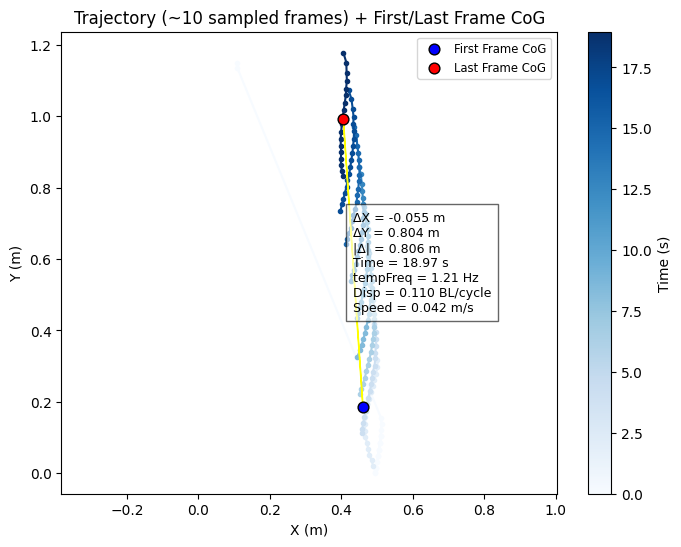


Done! Figure and a copy of the original CSV are in: 20250113_015735_displacement_plots


In [35]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# For color mapping
import matplotlib.cm as cm
import matplotlib.colors as mcolors

tempFreq = 1.21 # example parameter
bodyLength = 0.32 #m

##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_displacement_plots"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/32cm_twoMethods_trial_3/32cm_run8DLC_resnet50_32cm_newOct2shuffle1_100000.csv'

# (Optional) Copy the original CSV into the output folder
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.675

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 1080

# Video frame rate
video_fps = 60

# Load the CSV (DLC multi-level headers: rows 1 & 2)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates; drop rows with NaN
x_coords = data.xs('x', level=1, axis=1).dropna()
y_coords = data.xs('y', level=1, axis=1).dropna()

##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
n_drop_front = 0
n_drop_end = 300

if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

##############################################################################
# 2.2) CONVERT PIXELS -> METERS
##############################################################################
def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coords to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

x_m, y_m = pixels_to_meters(x_coords, y_coords)
x_coords = x_m
y_coords = y_m

##############################################################################
# 3) CALCULATE AVERAGE DISPLACEMENT (FIRST FRAME -> LAST FRAME)
##############################################################################

N_frames = x_coords.shape[0]
last_frame_idx = N_frames - 1

# First-frame CoG (mean of all markers)
mean_x_first = x_coords.iloc[0].mean()
mean_y_first = y_coords.iloc[0].mean()

# Last-frame CoG
mean_x_last = x_coords.iloc[last_frame_idx].mean()
mean_y_last = y_coords.iloc[last_frame_idx].mean()

# Displacement
disp_x = mean_x_last - mean_x_first
disp_y = mean_y_last - mean_y_first
disp_mag = np.sqrt(disp_x**2 + disp_y**2)

# Total time from first to last frame
total_time_s = (N_frames - 1) / video_fps
avg_speed = disp_mag / total_time_s  # m/s

print(f"Average displacement in X: {disp_x:.4f} m")
print(f"Average displacement in Y: {disp_y:.4f} m")
print(f"Total displacement magnitude: {disp_mag:.4f} m")
print(f"Total time: {total_time_s:.4f} s")
print(f"Average speed: {avg_speed:.4f} m/s")

##############################################################################
# 4) PLOT: TRAJECTORY (~10 FRAMES) COLORED BY TIME + FIRST/LAST FRAME CoG
##############################################################################

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Trajectory (~10 sampled frames) + First/Last Frame CoG")

# ~10 frames sampled across the entire sequence
n_samples = 10
sample_frames = np.linspace(0, last_frame_idx, n_samples, dtype=int)

# We'll color by time (in seconds):
sample_times = sample_frames / video_fps  # time for each sampled frame

# Use a sequential colormap from dark at t=0 to light at t=total_time_s
cmap = cm.get_cmap('Blues')  # black -> white
norm = mcolors.Normalize(vmin=0, vmax=total_time_s)

# Plot raw markers for each sampled frame
for i, f_idx in enumerate(sample_frames):
    this_time = sample_times[i]  # seconds
    frame_color = cmap(norm(this_time))
    ax.plot(
        x_coords.iloc[f_idx],
        y_coords.iloc[f_idx],
        'o-',
        markersize=3,
        color=frame_color,
        zorder=2
    )

# Plot CoG for first frame and last frame
ax.scatter(
    mean_x_first, mean_y_first,
    color='blue', s=60, edgecolors='k',
    zorder=10, label='First Frame CoG'
)
ax.scatter(
    mean_x_last, mean_y_last,
    color='red', s=60, edgecolors='k',
    zorder=10, label='Last Frame CoG'
)

# Draw arrow from first-frame CoG to last-frame CoG
ax.arrow(
    mean_x_first, mean_y_first,
    disp_x, disp_y,
    head_width=0.005, length_includes_head=True,
    color='yellow', zorder=9
)

# Annotate displacement & average speed
mid_x = mean_x_first + disp_x * 0.5
mid_y = mean_y_first + disp_y * 0.5

annotation_text = (
    f"ΔX = {disp_x:.3f} m\n"
    f"ΔY = {disp_y:.3f} m\n"
    f"|Δ| = {disp_mag:.3f} m\n"
    f"Time = {total_time_s:.2f} s\n"
    f"tempFreq = {tempFreq:.2f} Hz\n"
    f"Disp = {disp_mag/bodyLength/(total_time_s*tempFreq):.3f} BL/cycle\n"
    f"Speed = {avg_speed:.3f} m/s"
)

ax.text(
    mid_x, mid_y,
    annotation_text,
    fontsize=9,
    ha='left', va='center',
    bbox=dict(facecolor='white', alpha=0.6, pad=5),
    zorder=11
)

# Create a colorbar that maps time in [0, total_time_s] to the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Array not strictly needed, but required for colorbar
cb = fig.colorbar(sm, ax=ax)
cb.set_label("Time (s)")

ax.axis('equal')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend(fontsize='small', loc='best')

fig_save_path = os.path.join(save_folder, "figure_time_colormap.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

print("\nDone! Figure and a copy of the original CSV are in:", save_folder)


Will save outputs in: 20250113_023358_displacement_plots
Average displacement in X: -0.0948 m
Average displacement in Y: 0.8913 m
Total displacement magnitude: 0.8963 m
Total time: 19.6667 s
Average speed: 0.0456 m/s


/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/1883678591.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')  # black -> white


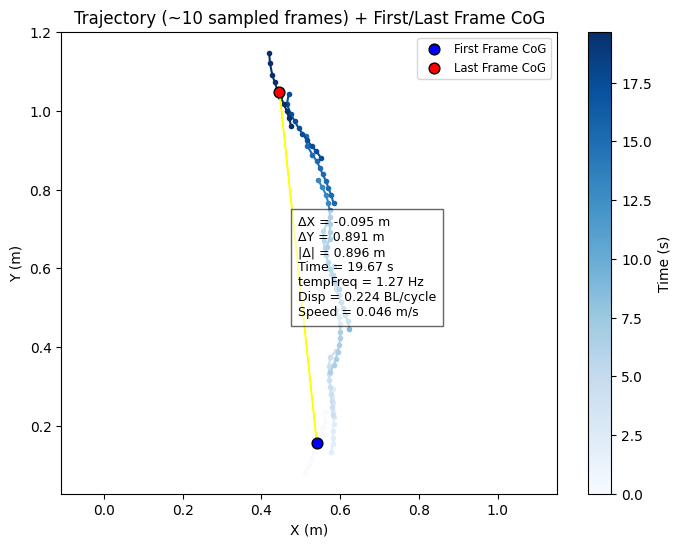


Done! Figure and a copy of the original CSV are in: 20250113_023358_displacement_plots


In [65]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil

# For color mapping
import matplotlib.cm as cm
import matplotlib.colors as mcolors

tempFreq = 1.27 # example parameter
bodyLength = 0.16 #m

##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_displacement_plots"
os.makedirs(save_folder, exist_ok=True)
print(f"Will save outputs in: {save_folder}")

##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/16cm_twoMethods_trial_3/16cm_run6DLC_resnet50_16cm_newOct3shuffle1_100000_filtered.csv'

# (Optional) Copy the original CSV into the output folder
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.675

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 1080

# Video frame rate
video_fps = 60

# Load the CSV (DLC multi-level headers: rows 1 & 2)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates; drop rows with NaN
x_coords = data.xs('x', level=1, axis=1).dropna()
y_coords = data.xs('y', level=1, axis=1).dropna()

##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
n_drop_front = 0
n_drop_end = 0

if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

##############################################################################
# 2.2) CONVERT PIXELS -> METERS
##############################################################################
def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coords to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

x_m, y_m = pixels_to_meters(x_coords, y_coords)
x_coords = x_m
y_coords = y_m

##############################################################################
# 3) CALCULATE AVERAGE DISPLACEMENT (FIRST FRAME -> LAST FRAME)
##############################################################################

N_frames = x_coords.shape[0]
last_frame_idx = N_frames - 1

# First-frame CoG (mean of all markers)
mean_x_first = x_coords.iloc[0].mean()
mean_y_first = y_coords.iloc[0].mean()

# Last-frame CoG
mean_x_last = x_coords.iloc[last_frame_idx].mean()
mean_y_last = y_coords.iloc[last_frame_idx].mean()

# Displacement
disp_x = mean_x_last - mean_x_first
disp_y = mean_y_last - mean_y_first
disp_mag = np.sqrt(disp_x**2 + disp_y**2)

# Total time from first to last frame
total_time_s = (N_frames - 1) / video_fps
avg_speed = disp_mag / total_time_s  # m/s

print(f"Average displacement in X: {disp_x:.4f} m")
print(f"Average displacement in Y: {disp_y:.4f} m")
print(f"Total displacement magnitude: {disp_mag:.4f} m")
print(f"Total time: {total_time_s:.4f} s")
print(f"Average speed: {avg_speed:.4f} m/s")

##############################################################################
# 4) PLOT: TRAJECTORY (~10 FRAMES) COLORED BY TIME + FIRST/LAST FRAME CoG
##############################################################################

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Trajectory (~10 sampled frames) + First/Last Frame CoG")

# ~10 frames sampled across the entire sequence
n_samples = 10
sample_frames = np.linspace(0, last_frame_idx, n_samples, dtype=int)

# We'll color by time (in seconds):
sample_times = sample_frames / video_fps  # time for each sampled frame

# Use a sequential colormap from dark at t=0 to light at t=total_time_s
cmap = cm.get_cmap('Blues')  # black -> white
norm = mcolors.Normalize(vmin=0, vmax=total_time_s)

# Plot raw markers for each sampled frame
for i, f_idx in enumerate(sample_frames):
    this_time = sample_times[i]  # seconds
    frame_color = cmap(norm(this_time))
    ax.plot(
        x_coords.iloc[f_idx],
        y_coords.iloc[f_idx],
        'o-',
        markersize=3,
        color=frame_color,
        zorder=2
    )

# Plot CoG for first frame and last frame
ax.scatter(
    mean_x_first, mean_y_first,
    color='blue', s=60, edgecolors='k',
    zorder=10, label='First Frame CoG'
)
ax.scatter(
    mean_x_last, mean_y_last,
    color='red', s=60, edgecolors='k',
    zorder=10, label='Last Frame CoG'
)

# Draw arrow from first-frame CoG to last-frame CoG
ax.arrow(
    mean_x_first, mean_y_first,
    disp_x, disp_y,
    head_width=0.005, length_includes_head=True,
    color='yellow', zorder=9
)

# Annotate displacement & average speed
mid_x = mean_x_first + disp_x * 0.5
mid_y = mean_y_first + disp_y * 0.5

annotation_text = (
    f"ΔX = {disp_x:.3f} m\n"
    f"ΔY = {disp_y:.3f} m\n"
    f"|Δ| = {disp_mag:.3f} m\n"
    f"Time = {total_time_s:.2f} s\n"
    f"tempFreq = {tempFreq:.2f} Hz\n"
    f"Disp = {disp_mag/bodyLength/(total_time_s*tempFreq):.3f} BL/cycle\n"
    f"Speed = {avg_speed:.3f} m/s"
)

ax.text(
    mid_x, mid_y,
    annotation_text,
    fontsize=9,
    ha='left', va='center',
    bbox=dict(facecolor='white', alpha=0.6, pad=5),
    zorder=11
)

# Create a colorbar that maps time in [0, total_time_s] to the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Array not strictly needed, but required for colorbar
cb = fig.colorbar(sm, ax=ax)
cb.set_label("Time (s)")

ax.axis('equal')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.legend(fontsize='small', loc='best')

fig_save_path = os.path.join(save_folder, "figure_time_colormap.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

print("\nDone! Figure and a copy of the original CSV are in:", save_folder)


/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/3390809189.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ro-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.errorbar(lengths,
/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/3390809189.py:65: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.errorbar(lengths,
/var/folders/wv/gyf44h3j2j7_0l6h0jpy65mm0000gn/T/ipykernel_45277/3390809189.py:75: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "ks-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(lengths,


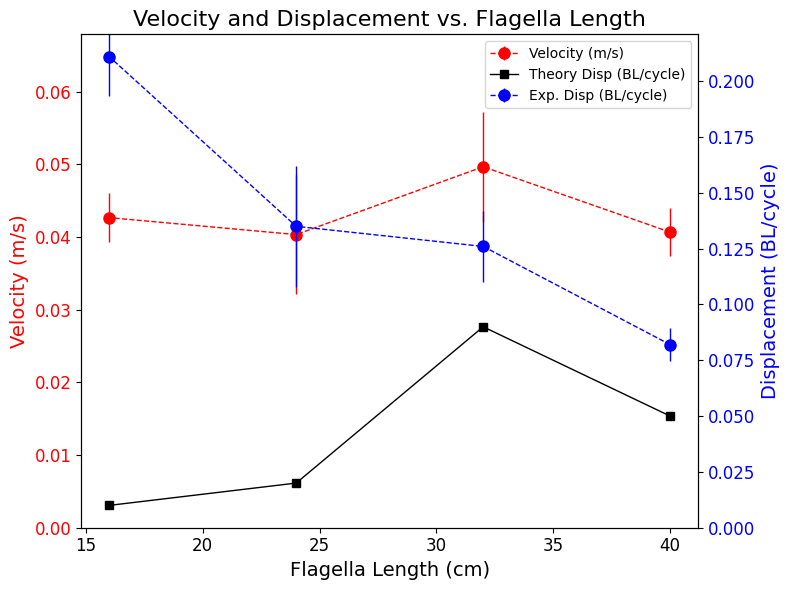

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Flagella lengths (cm), in descending order
lengths = [40, 32, 24, 16]

# Experimental velocity data (m/s)
velocity_data = {
    40: [0.043, 0.043, 0.036],
    32: [0.047, 0.060, 0.042],
    24: [0.051, 0.039, 0.031],
    16: [0.044, 0.038, 0.046]
}

# Experimental displacement (BL/cycle) data
disp_bl_data = {
    40: [0.085, 0.089, 0.072],
    32: [0.120, 0.148, 0.110],
    24: [0.169, 0.133, 0.103],
    16: [0.223, 0.186, 0.224]
}

# Theoretical displacement (BL/cycle) for each flagella length
# Notice these are stored using the same keys (40, 32, 24, 16)
theory_disp_data = {
    40: 0.05,
    32: 0.09,
    24: 0.02,
    16: 0.01
}

# Calculate mean and standard deviation for each flagella length (experimental data)
velocity_means = [np.mean(velocity_data[length]) for length in lengths]
velocity_std = [np.std(velocity_data[length]) for length in lengths]

disp_means = [np.mean(disp_bl_data[length]) for length in lengths]
disp_std = [np.std(disp_bl_data[length]) for length in lengths]

# Create a list of theoretical displacements, in descending order of length
theory_disp = [theory_disp_data[length] for length in lengths]

# Create the plot with two y-axes for velocity and displacement
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting velocity (experimental) with error bars on the left y-axis
ax1.set_xlabel('Flagella Length (cm)', fontsize=14)
ax1.set_ylabel('Velocity (m/s)', color='r', fontsize=14)
ax1.errorbar(lengths,
             velocity_means,
             yerr=velocity_std,
             fmt='ro-',
             label='Velocity (m/s)',
             markersize=8,
             linestyle='--',
             linewidth=1)
ax1.tick_params(axis='y', labelcolor='r', labelsize=12)
ax1.set_ylim(0, max(velocity_means) + max(velocity_std) + 0.01)
ax1.tick_params(axis='x', labelsize=12)

# Create a second y-axis for displacement
ax2 = ax1.twinx()
ax2.set_ylabel('Displacement (BL/cycle)', color='b', fontsize=14)

# Plot experimental displacement
ax2.errorbar(lengths,
             disp_means,
             yerr=disp_std,
             fmt='bo-',
             label='Exp. Disp (BL/cycle)',
             markersize=8,
             linestyle='--',
             linewidth=1)

# Plot theoretical displacement
ax2.plot(lengths,
         theory_disp,
         'ks-',
         label='Theory Disp (BL/cycle)',
         markersize=6,
         linestyle='-',
         linewidth=1)

ax2.tick_params(axis='y', labelcolor='b', labelsize=12)
ax2.set_ylim(0, max(disp_means + theory_disp) + 0.01)

# Collect legend labels from both axes and make a combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Set title
plt.title('Velocity and Displacement vs. Flagella Length', fontsize=16)
plt.tight_layout()
plt.show()


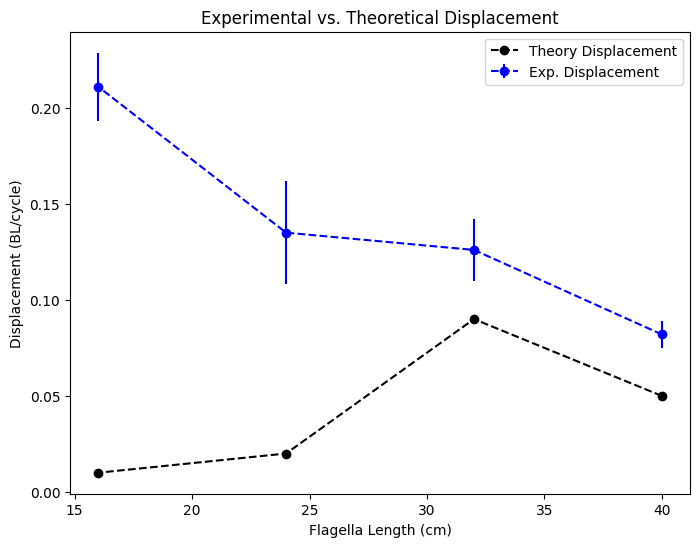

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Flagella lengths (cm)
lengths = [40, 32, 24, 16]

# Experimental displacement data (BL/cycle)
exp_disp_data = {
    40: [0.085, 0.089, 0.072],
    32: [0.120, 0.148, 0.110],
    24: [0.169, 0.133, 0.103],
    16: [0.223, 0.186, 0.224]
}

# Theoretical displacement (BL/cycle)
theory_disp_data = {
    40: 0.05,
    32: 0.09,
    24: 0.02,
    16: 0.01
}

# Calculate experimental means and standard deviations
exp_means = [np.mean(exp_disp_data[L]) for L in lengths]
exp_stds  = [np.std(exp_disp_data[L])  for L in lengths]

# Create a single plot for BL/cycle
plt.figure(figsize=(8, 6))
plt.errorbar(lengths, exp_means, yerr=exp_stds,
             fmt='bo--', label='Exp. Displacement',
             )

# Plot theoretical displacement
theory_disp = [theory_disp_data[L] for L in lengths]
plt.plot(lengths, theory_disp, 'ko--', label='Theory Displacement')

plt.xlabel('Flagella Length (cm)')
plt.ylabel('Displacement (BL/cycle)')
plt.title('Experimental vs. Theoretical Displacement')
plt.legend()
# plt.tight_layout()
plt.show()


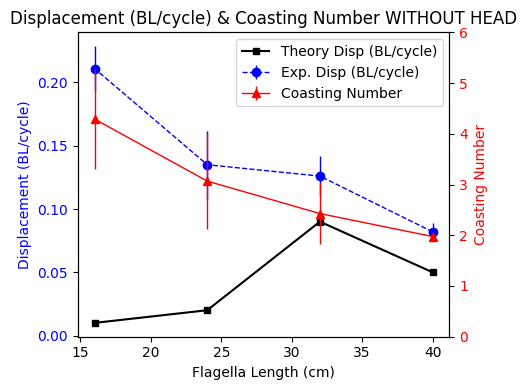

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# Flagella lengths (cm)
lengths = np.array([40, 32, 24, 16])

# Experimental displacement (BL/cycle)
exp_disp_data = {
    40: [0.085, 0.089, 0.072],
    32: [0.120, 0.148, 0.110],
    24: [0.169, 0.133, 0.103],
    16: [0.223, 0.186, 0.224]
}

# Theoretical displacement (BL/cycle)
theory_disp_data = {
    40: 0.05,
    32: 0.09,
    24: 0.02,
    16: 0.01
}

# Coasting number data for each tail length
measurements = np.array([
    [1.91, 3.42, 3.60, 5.49],
    [1.98, 1.85, 4.02, 3.82],
    [2.12, 2.03, 3.11, 4.93],
    [1.89, 2.41, 1.54, 2.92]
])

# Compute mean & std for experimental displacement
exp_means = [np.mean(exp_disp_data[L]) for L in lengths]
exp_stds  = [np.std(exp_disp_data[L])  for L in lengths]

# Prepare theoretical displacement
theory_disp = [theory_disp_data[L] for L in lengths]

# Compute mean & std for coasting number
coasting_mean = measurements.mean(axis=0)  # average across rows
coasting_std  = measurements.std(axis=0)

# Plot
fig, ax1 = plt.subplots(figsize=(5, 4))

# 1) Experimental displacement + error bars
exp_lines = ax1.errorbar(
    lengths, exp_means, yerr=exp_stds,
    fmt='bo--', markersize=6, linewidth=1, 
    label='Exp. Disp (BL/cycle)'
)

# 2) Theoretical displacement
theory_lines = ax1.plot(
    lengths, theory_disp, 'ks-', markersize=5, 
    label='Theory Disp (BL/cycle)'
)

ax1.set_xlabel('Flagella Length (cm)')
ax1.set_ylabel('Displacement (BL/cycle)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Displacement (BL/cycle) & Coasting Number WITHOUT HEAD')

# 3) Coasting number on a second y-axis
ax2 = ax1.twinx()
coast_lines = ax2.errorbar(
    lengths, coasting_mean, yerr=coasting_std,
    fmt='r^-', markersize=6, linewidth=1,
    label='Coasting Number'
)
ax2.set_ylim(0, 6)
ax2.set_ylabel('Coasting Number', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ---- Combine legends from both axes ----
# This ensures the ErrorbarContainer and Line2D objects are all recognized.
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()

ax1.legend(
    handles_ax1 + handles_ax2,
    labels_ax1 + labels_ax2,
    loc='best'
)

plt.tight_layout()
plt.show()


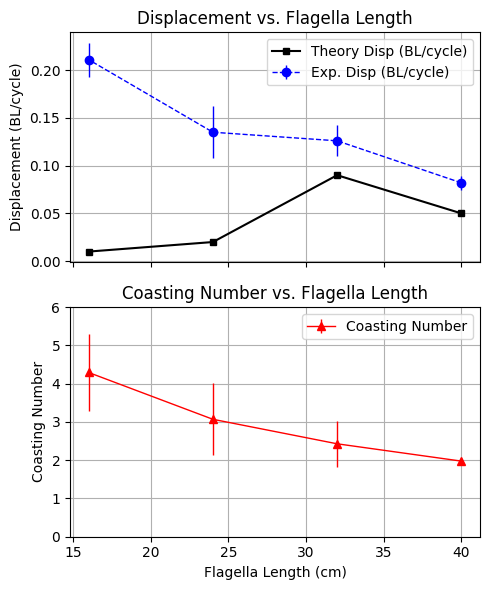

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Flagella lengths (cm)
lengths = np.array([40, 32, 24, 16])

# Experimental displacement (BL/cycle)
exp_disp_data = {
    40: [0.085, 0.089, 0.072],
    32: [0.120, 0.148, 0.110],
    24: [0.169, 0.133, 0.103],
    16: [0.223, 0.186, 0.224]
}

# Theoretical displacement (BL/cycle)
theory_disp_data = {
    40: 0.05,
    32: 0.09,
    24: 0.02,
    16: 0.01
}

# Coasting number data for each tail length
measurements = np.array([
    [1.91, 3.42, 3.60, 5.49],
    [1.98, 1.85, 4.02, 3.82],
    [2.12, 2.03, 3.11, 4.93],
    [1.89, 2.41, 1.54, 2.92]
])

# Compute mean & std for experimental displacement
exp_means = [np.mean(exp_disp_data[L]) for L in lengths]
exp_stds  = [np.std(exp_disp_data[L])  for L in lengths]

# Prepare theoretical displacement (in the same order as `lengths`)
theory_disp = [theory_disp_data[L] for L in lengths]

# Compute mean & std for coasting number
coasting_mean = measurements.mean(axis=0)  # average across rows
coasting_std  = measurements.std(axis=0)

# Create two subplots, one above the other, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 6), sharex=True)

# --- Subplot 1 (Displacement) ---
ax1.errorbar(
    lengths, exp_means, yerr=exp_stds,
    fmt='bo--', markersize=6, linewidth=1,
    label='Exp. Disp (BL/cycle)'
)
ax1.plot(
    lengths, theory_disp,
    'ks-', markersize=5,
    label='Theory Disp (BL/cycle)'
)
ax1.set_ylabel('Displacement (BL/cycle)')
ax1.set_title('Displacement vs. Flagella Length')
ax1.legend(loc='best')
ax1.grid(True)

# --- Subplot 2 (Coasting Number) ---
ax2.errorbar(
    lengths, coasting_mean, yerr=coasting_std,
    fmt='r^-', markersize=6, linewidth=1,
    label='Coasting Number'
)
ax2.set_ylim(0, 6)  # Force the axis range from 0 to 6
ax2.set_xlabel('Flagella Length (cm)')
ax2.set_ylabel('Coasting Number')
ax2.set_title('Coasting Number vs. Flagella Length WITHOUTHEAD')
ax2.legend(loc='best')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Flagella lengths (cm)
lengths = np.array([40, 32, 24, 16])

# Experimental displacement (BL/cycle)
exp_disp_data = {
    40: [0.071,0.075,0.060],
    32: [0.096,0.118,0.088],
    24: [0.127,0.100,0.078],
    16: [0.149,0.124,0.149]
}

# Theoretical displacement (BL/cycle)
theory_disp_data = {
    40: 0.05,
    32: 0.09,
    24: 0.02,
    16: 0.01
}

# Coasting number data for each tail length
measurements = np.array([
    [1.91, 3.42, 3.60, 5.49],
    [1.98, 1.85, 4.02, 3.82],
    [2.12, 2.03, 3.11, 4.93],
    [1.89, 2.41, 1.54, 2.92]
])

# Compute mean & std for experimental displacement
exp_means = [np.mean(exp_disp_data[L]) for L in lengths]
exp_stds  = [np.std(exp_disp_data[L])  for L in lengths]

# Prepare theoretical displacement
theory_disp = [theory_disp_data[L] for L in lengths]

# Compute mean & std for coasting number
coasting_mean = measurements.mean(axis=0)  # average across rows
coasting_std  = measurements.std(axis=0)

# Plot
fig, ax1 = plt.subplots(figsize=(5, 4))

# 1) Experimental displacement + error bars
exp_lines = ax1.errorbar(
    lengths, exp_means, yerr=exp_stds,
    fmt='bo--', markersize=6, linewidth=1, 
    label='Exp. Disp (BL/cycle)'
)

# 2) Theoretical displacement
theory_lines = ax1.plot(
    lengths, theory_disp, 'ks-', markersize=5, 
    label='Theory Disp (BL/cycle)'
)

ax1.set_xlabel('Flagella Length (cm)')
ax1.set_ylabel('Displacement (BL/cycle)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Displacement (BL/cycle) & Coasting Number WITH HEAD')

# 3) Coasting number on a second y-axis
ax2 = ax1.twinx()
coast_lines = ax2.errorbar(
    lengths, coasting_mean, yerr=coasting_std,
    fmt='r^-', markersize=6, linewidth=1,
    label='Coasting Number'
)
ax2.set_ylim(0, 6)
ax2.set_ylabel('Coasting Number', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ---- Combine legends from both axes ----
# This ensures the ErrorbarContainer and Line2D objects are all recognized.
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()

ax1.legend(
    handles_ax1 + handles_ax2,
    labels_ax1 + labels_ax2,
    loc='best'
)

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (659054925.py, line 9)